In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from libraries_functions import *
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

d:\Anaconda\envs\Javier_waveinet\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
path_voice = "./data_tests/voice_sounds/"
path_noise_use= "./data_tests/noise_use/"
chunked_voice = "./data_tests/chunked_voice/"

path_save_mixed= "./data_tests/mixed_order/mixed_sounds/"
path_save_noise= "./data_tests/mixed_order/noise_order/"
path_save_voice= "./data_tests/mixed_order/voice_order/"

In [4]:
MONO = True
PATH_TO_MODEL= "./model/"
PATH_TO_VOICES="./data_tests/mixed_order/voice_order/"
SPECTROGRAMS_SAVE_DIR = "./data_tests/espectrogramas/"
MIN_MAX_VALUES_SAVE_DIR = "./data_tests/min_max/"
MIN_MAX_VALUES = "./data_tests/min_max/min_max_values.pkl"
FILES_DIR = "./data_tests/mixed_order/mixed_sounds/"
SAVE_DIR_ORIGINAL="./data_tests/model_generated/original/"
SAVE_DIR_GENERATED="./data_tests/model_generated/generated/"
SAVE_DIR_REAL="./data_tests/model_generated/real/"

In [5]:
def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=2):

    file_paths = [file_paths[index] for index in range(len(spectrograms))]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                           file_paths]
    print(file_paths)
    return spectrograms, sampled_min_max_values, file_paths

def load_form_direc(dir_path):
    train=[]
    file_paths=[]
    for root, _, filenames in os.walk(dir_path):
        for file_name in sorted(filenames, key=lambda x: (int(x.split("_")[1].split(".")[0]))):
            print(file_name)
            filepath= os.path.join(root, file_name)
            spectrogram=np.load(filepath)
            train.append(spectrogram)
            file_paths.append(filepath)
        train=np.array(train)
        train = train[..., np.newaxis]

    return train, file_paths

def load_min_max(min_max_path):
    with open (min_max_path, "rb") as f:
        min_max_values = pickle.load(f)
    return min_max_values

def save_signals(signals, save_dir,voice_paths,type, sample_rate=22050):
    py_files_m = glob.glob(f'{save_dir}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file)
        except OSError as e:
            print(f"Error:{ e.strerror}")
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, type+voice_paths[i] + ".wav")
        print(save_path)
        sf.write(save_path, signal, sample_rate)

def preprocess_files():
    ## Ejecutar solo si no tenemos los tests generados correctamente

    py_files_m = glob.glob(f'{SPECTROGRAMS_SAVE_DIR}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file)
        except OSError as e:
            print(f"Error:{ e.strerror}")

    py_files_m = glob.glob(f'{MIN_MAX_VALUES_SAVE_DIR}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file) 
        except OSError as e:
            print(f"Error:{ e.strerror}")


    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION,MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(N_FFT, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver= Saver(SPECTROGRAMS_SAVE_DIR,MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

def convert_spectrograms_to_audio(spectrograms, min_max_values, noise, files_path, model_name= None):
    x=0
    _min_max_normaliser=MinMaxNormaliser(0, 1)
    signals = []
    path_signals=[]
    for spectrogram, min_max_value, files_path in zip(spectrograms, min_max_values, files_path):
        # reshape the log spectrogram
        log_spectrogram = spectrogram[:, :, 0]
        # apply denormalisation
        denorm_log_spec = _min_max_normaliser.denormalise(
            log_spectrogram, min_max_value["min"], min_max_value["max"])
        librosa.display.specshow(denorm_log_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)## Nos permite visualizar como un mapa de calor
        name="mixed"if noise else "predicted"
        plt.title(f"{name}_Name:{files_path}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        if model_name!=None and x==0:
            plt.savefig("./data_tests/espectrograms_images/"+model_name+".png")
            x=1
        plt.show()
        # log spectrogram -> spectrogram
        spec = librosa.db_to_amplitude(denorm_log_spec)
        # apply Griffin-Lim
        _, phase= librosa.magphase(spec)
        #signal = librosa.istft(spec*phase, hop_length=self.hop_length)
        signal = librosa.istft(spec*min_max_value["mag_phase"], hop_length=HOP_LENGTH)

        # append signal to "signals"
        signals.append(signal)
        path_signals.append(files_path)
    return signals, path_signals

def spectrograms_of_voice(file_path):
    signals = []
    path_signals=[]
    for spectrogram in (file_path):
        signal_noise, sr_noise = librosa.load(spectrogram, sr=SAMPLE_RATE, mono=True)

        stft_mixed= librosa.stft(signal_noise, n_fft=N_FFT, hop_length=HOP_LENGTH)[:-1]
        spectrogram_mixed= np.abs(stft_mixed)
        log_spectrogram_mixed= librosa.amplitude_to_db(spectrogram_mixed)

        librosa.display.specshow(log_spectrogram_mixed, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)## Nos permite visualizar como un mapa de calor
        plt.title(f"voice_{spectrogram}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()
        # append signal to "signals"
        signals.append(signal_noise)
        path_signals.append(spectrogram)
    return signals, path_signals

def search_voices(file_path):
    def know_number_spec(file_path):
        paths=[]
        for file in file_path:
            file_cut=file.split("_")[-1].split(".")[0]
            paths.append(file_cut)
        return paths

    def find_noise(mixed_numbers):
        voice_paths=[]
        py_files_m = glob.glob(f'{PATH_TO_VOICES}*')
        for py_file in py_files_m:
            file=(py_file.split("_")[-1].split(".")[0])
            if(file in mixed_numbers):
                voice_paths.append(py_file)
        return voice_paths
    mixed_numbers=know_number_spec(file_path)
    voice_paths=find_noise(mixed_numbers)
    print(voice_paths)
    return voice_paths


In [6]:
generar_samplerate(True) #"./data_tests/noisy_sound/"
generar_samplerate(False)# "./data_tests/voice_sounds/"
chunk_large_audio(path_voice,chunked_voice)# Chunk TED audio
mixingData(path_Noise=path_noise_use,path_TED_Talks=chunked_voice,path_save_mixed=path_save_mixed,path_save_noise=path_save_noise,path_save_voice=path_save_voice)

Estandarized TED audios


100%|██████████| 1/1 [00:00<00:00, 652.51it/s]


Estandarized noisy audios


100%|██████████| 9/9 [00:00<00:00, 58.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

## Preprocess for network

In [7]:
preprocess_files()

100%|██████████| 4/4 [00:00<00:00, 32.67it/s]

Processed file ./data_tests/mixed_order/mixed_sounds/javier_0.wav


In [8]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_direc(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=4)
voice_paths= search_voices(file_path)

javier_0.wav.npy
javier_1.wav.npy
javier_2.wav.npy
javier_3.wav.npy
['./data_tests/espectrogramas/javier_0.wav.npy', './data_tests/espectrogramas/javier_1.wav.npy', './data_tests/espectrogramas/javier_2.wav.npy', './data_tests/espectrogramas/javier_3.wav.npy']
['./data_tests/mixed_order/voice_order\\javier_0.wav', './data_tests/mixed_order/voice_order\\javier_1.wav', './data_tests/mixed_order/voice_order\\javier_2.wav', './data_tests/mixed_order/voice_order\\javier_3.wav']


In [9]:
model_name="VAE_weights_build_VAE_Skipp_complejo_loss_0.01_alpha_0.5_dim_400"
alpha=0.5
latent=400
learning_rate=0.0001
# vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)
vae, _=VAE.load_model_complete(sampled_specs,alpha,latent,learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=f"{model_name}.h5")

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

d:\Anaconda\envs\Javier_waveinet\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


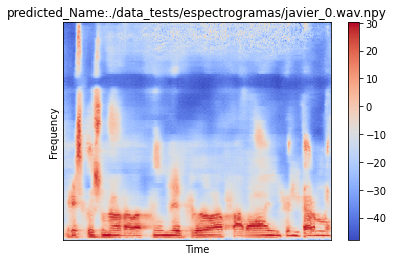

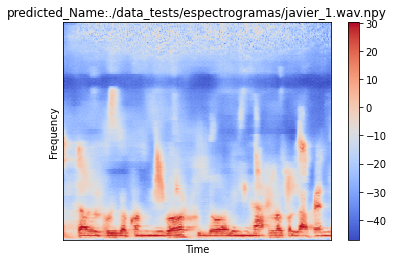

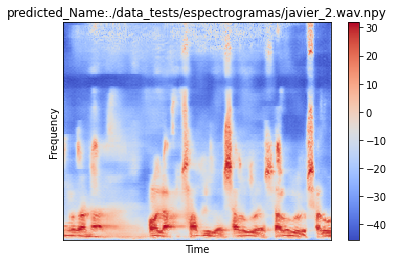

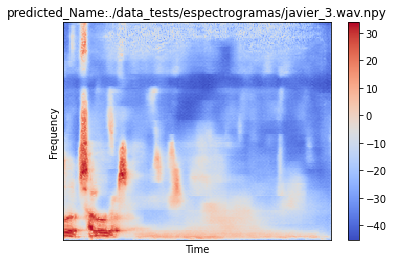

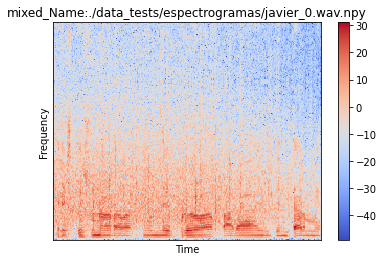

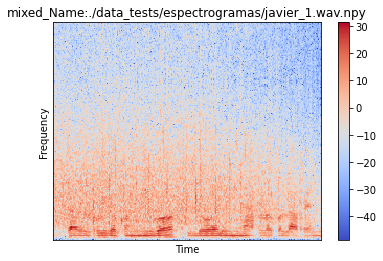

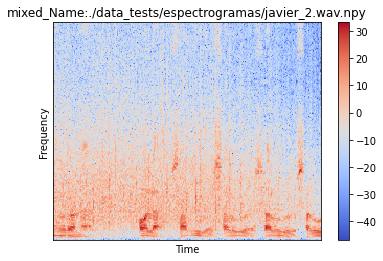

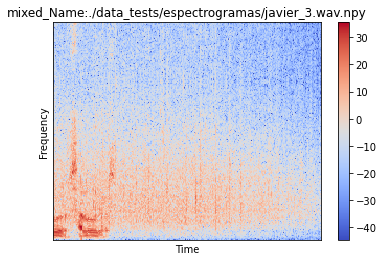

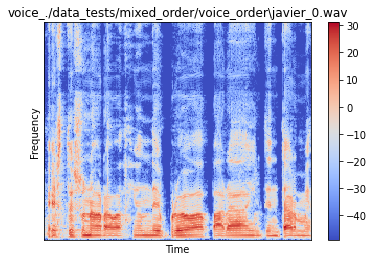

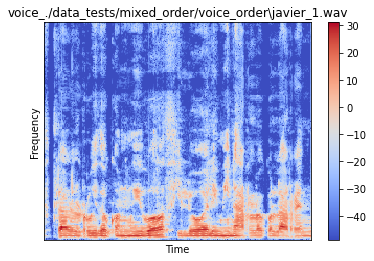

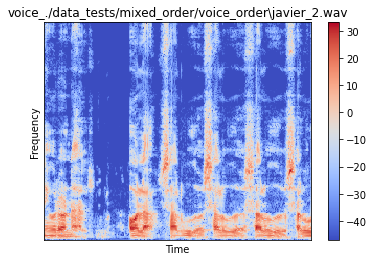

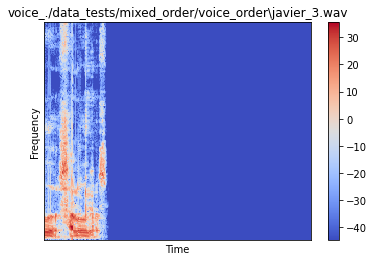

In [10]:
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path, model_name)

original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)

real_signals, real_path=spectrograms_of_voice(voice_paths)

In [11]:
for i in range(len(predicted_path)):
    predicted_path[i]=predicted_path[i].split("/")[-1].split(".")[0]
for i in range(len(mixed_path)):
    mixed_path[i]=mixed_path[i].split("/")[-1].split(".")[0]
for i in range(len(real_path)):
    real_path[i]=real_path[i].split("\\")[-1].split(".")[0]

In [12]:
save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_")
save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_")
save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_")
concatenate_audios(SAVE_DIR_GENERATED)

./data_tests/model_generated/generated/predicted_javier_0.wav
./data_tests/model_generated/generated/predicted_javier_1.wav
./data_tests/model_generated/generated/predicted_javier_2.wav
./data_tests/model_generated/generated/predicted_javier_3.wav
./data_tests/model_generated/original/mixed_javier_0.wav
./data_tests/model_generated/original/mixed_javier_1.wav
./data_tests/model_generated/original/mixed_javier_2.wav
./data_tests/model_generated/original/mixed_javier_3.wav
./data_tests/model_generated/real/real_javier_0.wav
./data_tests/model_generated/real/real_javier_1.wav
./data_tests/model_generated/real/real_javier_2.wav
./data_tests/model_generated/real/real_javier_3.wav


  0%|          | 0/3 [00:00<?, ?it/s]